In [1]:
%matplotlib inline

## 11.3
Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

In [80]:
from numpy.random import rand
def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs

In [81]:
training_1 = generateData(100)
training_2 = generateData(100)

In [82]:
import matplotlib.pyplot as plt

def dataPlot(data1):
    cols = {1:'b', -1: 'r'}
    for dp in data1:
        plt.plot(dp[0], dp[1], cols[dp[2]]+'o')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    

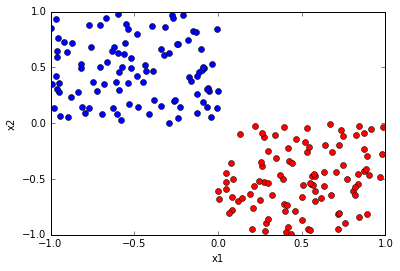

In [83]:
dataPlot(training_1)

In [84]:
from numpy.random import rand
def generateDataMessy(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    for i in range(len(xb)):
        if rand(1)[0] <= .1:
            xb[i] = xb[i] * -1
            yb[i] = yb[i] * -1
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    for i in range(len(xb)):
        if rand(1)[0] <= .1:
            xr[i] = xr[i] * -1
            yr[i] = yr[i] * -1
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

In [85]:
messy_train = generateDataMessy(100)
messy_test = generateDataMessy(100)

In [86]:
print messy_train[0][:2]

[-0.52966743042631681, 0.82107283480781168]


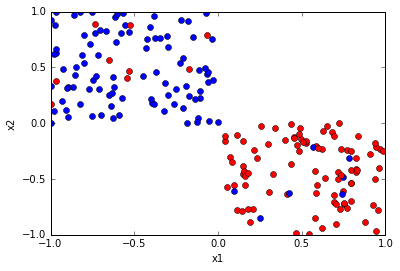

In [87]:
dataPlot(messy_train)

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

In [70]:
import findspark
findspark.init()
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark import SparkConf, SparkContext

In [56]:
conf = SparkConf().setMaster('local').setAppName('myApp')
sc = SparkContext(conf = conf)

In [256]:
def parsePoint(data):
    if data[0] < 0:
        return LabeledPoint(0, data[:2])
    else:
        return LabeledPoint(1, data[:2])

In [93]:
data = sc.parallelize(messy_train)

In [94]:
parsedData = data.map(parsePoint)

In [188]:
model = LogisticRegressionWithLBFGS.train(parsedData, iterations = 500)

In [189]:
type(model)

pyspark.mllib.classification.LogisticRegressionModel

In [190]:
model.weights

DenseVector([-2.3296, 1.7291])

In [111]:
test_data = sc.parallelize(messy_test)
parsedTestData = test_data.map(parsePoint)

In [112]:
parsedTestData

PythonRDD[175] at RDD at PythonRDD.scala:43

In [ ]:
broadcastModel = sc.broadcast(model)

In [104]:
type(broadcastModel.value)

pyspark.mllib.classification.LogisticRegressionModel

In [ ]:
predictions = parsedTestData.map(lambda x: (x.label, broadcastModel.value.predict(x.features)))

In [125]:
predictions

PythonRDD[180] at RDD at PythonRDD.scala:43

In [127]:
predictions.map(lambda x: (x[0] == x[1], 1)).reduceByKey(lambda x, y: x + y).collect()

[(False, 14), (True, 186)]

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

In [ ]:
import numpy as np

In [225]:
def data_generate(seperable=True):
    size = 100
    np.random.seed(0)
    x1 = np.random.uniform(-4,4,100)
    x2 = np.random.uniform(-4,4,100)
    coeff = [8,-3,2]
    b = coeff.pop()
    sd = sum([c*c for c in coeff])**0.5
    coeff.append(b)
    coeff = [c/sd for c in coeff]
    v = (x1*coeff[0]+x2*coeff[1] + coeff[2])
    y = (v>0)*2-1
    data = np.column_stack((x1,x2))
    idx = abs(v)>1
    data = data[idx,:]
    y = y[idx]
    if not seperable:
        wrongidx = np.random.choice(range(len(y)),6, replace =False )
        y[wrongidx] = -y[wrongidx]
    return data, y, coeff

In [228]:
messy_train_data, messy_train_y, messy_train_w = data_generate(False)

In [229]:
messy_train_data.shape

(69, 2)

In [284]:
def lassoLogisticRegression(data, y):
    dataRDD = sc.parallelize(np.append(y[:,None], data, axis=1)).cache()
    w = np.random.normal(size=data.shape[1] + 1)
    for i in range(500):
        w_broadcast = sc.broadcast(w)
        g = dataRDD.map(lambda x: -x[0]*(1-1/(1+np.exp(-x[0]*np.dot(w_broadcast.value,np.append(x[1:],1))))) \
                        *np.append(x[1:], 1)).reduce(lambda x, y: x + y) / data.shape[0]
#         g = dataRDD.map(lambda x: -x[0]*(1-1/(1+np.exp(-x[0]*np.dot(w_broadcast.value,np.append(x[1:],1))))) \
#                         *np.append(x[1:], 1)).reduce(lambda x, y: x + y) / data.shape[0] # Gradient of logloss
        wreg = w*1
        wreg[-1] = 0
        wreg = (wreg>0).astype(int)*2-1
        wdelta = .05 * (g + .01* wreg)
        if sum(abs(wdelta)) < .0001*sum(abs(w)):
            break
        w = w - wdelta
    return w

In [287]:
homegrown_coeffs = lassoLogisticRegression(messy_train_data, messy_train_y)

In [288]:
homegrown_coeffs

array([ 0.88772425, -0.04985349, -0.15249041])

## 11.4
Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 

In [ ]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

In [277]:
messy_train_data[:5]

array([[ 1.72151493, -1.83993621],
       [ 1.1671529 ,  0.60925868],
       [ 3.13418401,  0.57801525],
       [ 3.70930208, -2.21534694],
       [-0.93246785,  3.62199209]])

In [264]:
raw_data = np.append(messy_train_y[:,None], messy_train_data, axis=1)

In [265]:
data = sc.parallelize(raw_data).cache()

In [266]:
data.collect()[:5]

[array([ 1.        ,  1.72151493, -1.83993621]),
 array([ 1.        ,  1.1671529 ,  0.60925868]),
 array([-1.        ,  3.13418401,  0.57801525]),
 array([ 1.        ,  3.70930208, -2.21534694]),
 array([-1.        , -0.93246785,  3.62199209])]

In [267]:
parsed_data = data.map(parsePoint)

In [268]:
model = SVMWithSGD.train(parsed_data, iterations=100)

In [269]:
model.weights

DenseVector([1.5153, 0.1261])

Derive and Implement in Spark a weighted soft linear svm classification learning algorithm.
Evaluate your homegrown weighted soft linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up?

Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set. 

In [291]:
def SVMGD(data, y):
#     dataRDD = sc.parallelize(np.append(y[:,None], data, axis=1)).cache()
    dataRDD = sc.parallelize(np.append(y[:,None], data, axis=1)).cache() #prepend y to X
    w = np.random.normal(size=data.shape[1] + 1)
    for i in range(100):
        sv = dataRDD.filter(lambda x: x[0]*np.dot(w, np.append(x[1:], 1)) < 1)
        if sv.isEmpty():
            break
        g = -sv.map(lambda x: x[0]*np.append(x[1:], 1)).reduce(lambda x, y: x + y) / data.shape[0]
        wreg = w*1
        wreg[-1] = 0
        wdelta = .01 * (g + .01*wreg)
        if sum(abs(wdelta)) <= .0001*sum(abs(w)):
            break
        w = w - wdelta
    return w

In [293]:
model2 = SVMGD(messy_train_data, messy_train_y)

In [294]:
model2

array([ 0.44760919, -0.23576806, -0.0432523 ])